In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
#service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
from qiskit import *
import math
import matplotlib.pyplot as plt

In [3]:
# Define the list of paths
paths = [
    '10011', '01001', '10100', '00001', '10101', '11000', '10111', '00101',
    '11101', '10001', '10000', '00000', '11010', '00011', '11011', '11001',
    '01000', '10110', '10010', '11111', '11100', '00100', '01101', '00111',
    '11110', '00110', '00010', '01100', '01010', '01011', '01111', '01110']

# Define the target state
target_states = ['10101', '10010', '01001']

# Determine the number of qubits required
num_qubits = len(target_states[0])

In [4]:
def create_oracle(target_state, identifier):
    n = len(target_state)
    oracle = QuantumCircuit(n)

    # Apply X-gates to prepare the target_state (bit-flip oracle)
    for i, bit in enumerate(target_state):
        if bit == '0':
            oracle.x(i)

    # Apply a multi-controlled Z-gate (phase inversion)
    oracle.h(n-1)
    oracle.mct(list(range(n-1)), n-1)  # Multi-Control Toffoli
    oracle.h(n-1)

    # Uncompute the X-gates
    for i, bit in enumerate(target_state):
        if bit == '0':
            oracle.x(i)

    # Convert to a gate and name it with the identifier
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "Oracle-" + identifier
    return oracle_gate

def prepare_oracles(target_states):
    oracles = []
    for i, target_state in enumerate(target_states):
        oracle_gate = create_oracle(target_state, target_states[i])
        oracles.append(oracle_gate)
    return oracles

oracle_gates = prepare_oracles(target_states)


In [5]:
def create_grover_diffusion(n):
    grover_diffusion = QuantumCircuit(n)

    # Apply H-gates to all qubits
    grover_diffusion.h(range(n))

    # Apply multi-controlled Z-gate (inversion about the mean)
    grover_diffusion.x(range(n))
    grover_diffusion.h(n-1)
    grover_diffusion.mct(list(range(n-1)), n-1)
    grover_diffusion.h(n-1)
    grover_diffusion.x(range(n))

    # Convert to a gate
    grover_diffusion_gate = grover_diffusion.to_gate()
    grover_diffusion_gate.name = "Diffusion"
    return grover_diffusion_gate

grover_diffusion_gate = create_grover_diffusion(num_qubits)

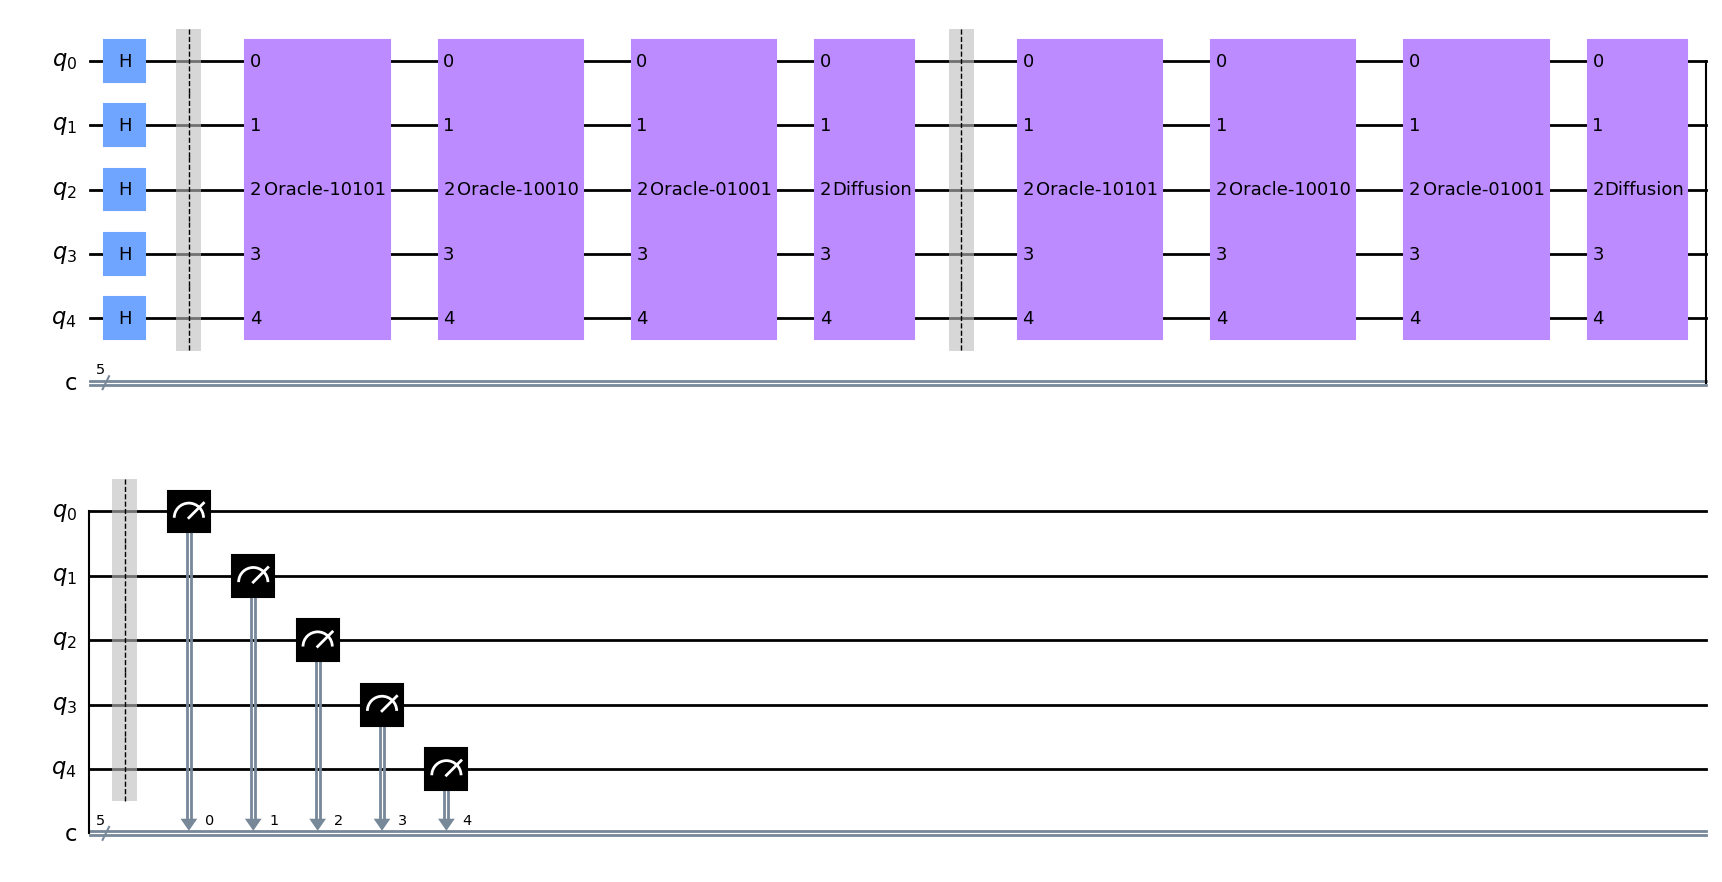

In [15]:
# Create a quantum circuit with the necessary qubits
grover_circuit = QuantumCircuit(num_qubits, num_qubits)

# Step 1: Initialize the superposition of states
grover_circuit.h(range(num_qubits))
grover_circuit.barrier()

# Step 2: Define the number of Grover iterations
num_iterations = 2  # Adjust as needed

# Step 3: Perform Grover iterations
for _ in range(num_iterations):
    # Append the oracle gates to the grover_circuit
    for oracle_gate in oracle_gates:
        grover_circuit.append(oracle_gate, range(len(target_states[0])))
    grover_circuit.append(grover_diffusion_gate, range(num_qubits))
    grover_circuit.barrier()

# Step 4: Measure the qubits
grover_circuit.measure(range(num_qubits), range(num_qubits))

grover_circuit.draw("mpl")

In [16]:
# Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
job = execute(grover_circuit, simulator, shots=1024*100)
result = job.result()
counts = result.get_counts()

{'11001': 3108, '10001': 5097, '00101': 3158, '01001': 12824, '10101': 20018, '00111': 4991, '10010': 12832, '11011': 1777, '10011': 3207, '01010': 5013, '00000': 1736, '11100': 5061, '00010': 3116, '01111': 3234, '01101': 1850, '01000': 3226, '11110': 3187, '01100': 206, '01110': 796, '10100': 3138, '11101': 204, '10000': 206, '10110': 1778, '00110': 210, '10111': 209, '00011': 796, '11000': 823, '11010': 213, '00001': 193, '01011': 193}
Most likely state: 10101


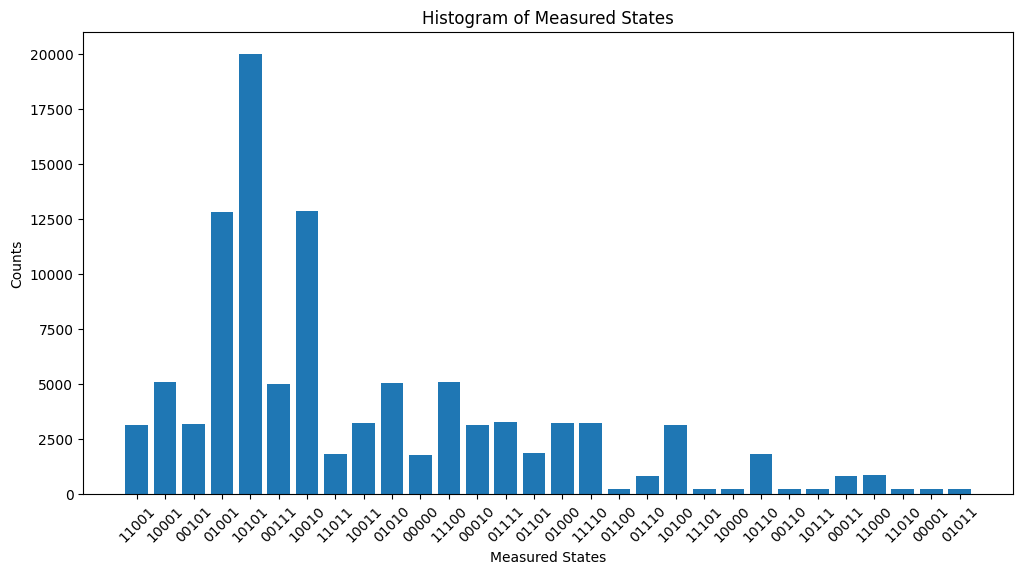

In [17]:
# Print the measurement results
print(counts)

# Find the state with the highest probability
max_state = max(counts, key=counts.get)
# Print the results
print("Most likely state:", max_state)

# Plot the histogram of the results
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
plt.bar(counts.keys(), counts.values())
plt.xlabel('Measured States')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.title('Histogram of Measured States')
plt.show()